We plot the all the ARGO profilers data corresponding to a given month.

In [9]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import glob
import os
import seawater
import cmocean
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [10]:
rcParams.update({'font.size': 16})
figdir = "/home/ctroupin/Projects2/201501_InsTAC/Graphical _Material/2016_Q2/Profilers/"
datadir = "/data_local/DataOceano/CMEMS/INSITU_GLO_NRT_OBSERVATIONS_013_030/monthly/profiler-glider"
dlon, dlat = 2., 1.

Create rectangular regions where we will check if we have data

In [14]:
regions = [[0.0, 30., 30., 45.], 
           [-50, 0.0, 40., 80.],
           [-50., 0.0, -20., 0.],
           [100., 150., -60., -40.]] 

In [ ]:
for key, value in regions.iteritems():
    print value

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


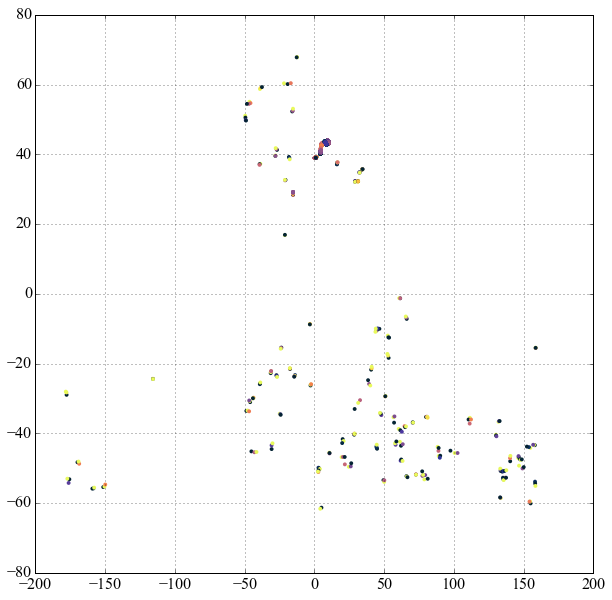

In [24]:
datafilelist = sorted(glob.glob(os.path.join(datadir, '*.nc')))
fig = plt.figure(figsize=(10, 10))
for datafiles in datafilelist[0:100]:
    # print('Working on %s' %(datafiles))
    figbasename = os.path.basename(datafiles)[:-3]
          
    # Read the variables from the data file
    time, time_units, lon, lat, pressure, temp, temp_qc, psal, psal_qc = read_variables(datafiles)
    
    # Convert time to dates and change the vector to a 2D array
    datesarray = convert_time(time, time_units)
    
    # Compute initial and final dates
    dayinit, dayend = get_init_final_dates(datesarray)
    
    # Apply QC
    temp, psal = apply_qc_variables(temp, temp_qc, psal, psal_qc)
    
    # Convert pressure to depth using [Soaunders (1981)] formula
    depth = seawater.eos80.dpth(pressure, np.tile(lat, (pressure.shape[1], 1)).T)
    
    # Plots:
    # -----------------------------
    
    psal_surf = psal[:, 0]
    plt.scatter(lon, lat, s=15, c=psal_surf, edgecolor='None', cmap=cmocean.cm.temperature)
plt.grid()
plt.show()
    # T-S diagram
    # density, density2plot = compute_density()
    # plot_TS(temp, psal, depth)
    
    # Trajectory of the profiler
    #plot_trajectory(lon, lat, dlon, dlat, figbasename, dayinit, dayend)

In [16]:
def read_variables(datafiles):
    with netCDF4.Dataset(datafiles) as nc:
        time = nc.variables['TIME'][:]
        time_units = nc.variables['TIME'].units
        lon = nc.variables['LONGITUDE'][:]
        lat = nc.variables['LATITUDE'][:]
        pressure = nc.variables['PRES'][:]
        temp = nc.variables['TEMP'][:]
        temp_qc = nc.variables['TEMP_QC'][:]
        psal = nc.variables['PSAL'][:]
        psal_qc = nc.variables['PSAL_QC'][:]
    return time, time_units, lon, lat, pressure, temp, temp_qc, psal, psal_qc

In [17]:
def convert_time(time, time_units):
    '''Convert time to dates and change the vector to a 2D array.'''
    dates = netCDF4.num2date(time, time_units)
    datesarray = np.tile(dates, (pressure.shape[1], 1)).T
    return datesarray

In [18]:
def get_init_final_dates(datesarray):
    '''Compute initial and final dates'''
    dayinit = datesarray[0, 0].strftime('%d %B %Y')
    dayend = datesarray[-1, 0].strftime('%d %B %Y')
    return dayinit, dayend

In [19]:
def apply_qc_variables(temp, temp_qc, psal, psal_qc):
    '''Apply the quality flags (we keep only the good values'''
    temp = np.ma.masked_where(temp_qc != 1, temp)
    psal = np.ma.masked_where(psal_qc != 1, psal)
    # chloro = np.ma.masked_where(chloro_qc > 3., chloro)
    return temp, psal

In [20]:
def plot_TS(temp, psal, depth):
    figname = figbasename + '_TSdiagram'
    
    tmin = np.floor(temp.min())
    tmax = np.ceil(temp.max())
    smin = np.floor(psal.min())
    smax = np.ceil(psal.max())
    
    # Compute density for different T-S pairs
    density2plot = np.arange(24, 30, .5)
    ds, dt = 0.05, 0.1
    tvec = np.arange(tmin, tmax, dt)
    svec = np.arange(smin, smax, ds)
    ssvec, ttvec = np.meshgrid(svec, tvec)
    density = seawater.eos80.dens0(ssvec, ttvec) - 1000.0
    
    # Make the plot
    fig = plt.figure(figsize=(15, 15))
    plt.scatter(psal, temp, s=5, c=depth,
               edgecolor='None', cmap=cmocean.cm.swh)
    cbar = plt.colorbar()
    plt.xlabel('Salinity', fontsize=18)
    plt.ylabel('Temperature\n($^{\circ}$C)', rotation=0, ha='right', fontsize=18)
    cont = plt.contour(svec, tvec, density, levels=density2plot, colors='.65', linestyles='dashed')
    plt.clabel(cont,inline=True, fmt='%1.1f')
    #plt.xlim(smin, smax)
    #plt.ylim(tmin, tmax)
    cbar.set_label('Depth\n(m)', rotation=0, ha='left')
    plt.savefig(os.path.join(figdir, figname), dpi=300)
    plt.close()

In [21]:
def plot_trajectory(lon, lat, dlon, dlat, figbasename, dayinit, dayend):
    
    coordinates = np.floor(lon.min()), np.ceil(lon.max()), np.floor(lat.min()), np.ceil(lat.max())
    
    m = Basemap(projection='merc', llcrnrlon=coordinates[0], llcrnrlat=coordinates[2],
                    urcrnrlon=coordinates[1], urcrnrlat=coordinates[3],
                    lat_ts=0.5 * (coordinates[2] + coordinates[3]), resolution='i')
    figname = figbasename + '_trajectory'
    fig = plt.figure(figsize=(12, 12))

    lonproj, latproj = m(lon, lat)
    m.plot(lonproj, latproj, 'ko-')
    m.plot(lonproj[0], latproj[0], '>g', markersize=15, zorder=2, label='Starting point')
    m.plot(lonproj[-1], latproj[-1], 'sr', markersize=15, zorder=2, label='Final point')
    m.drawparallels(np.arange(round(coordinates[2]), coordinates[3], dlat), linewidth=0.2,
                    labels=[1, 0, 0, 0], fontname='Times New Roman', fontsize=16, zorder=1)
    m.drawmeridians(np.arange(round(coordinates[0]), coordinates[1], dlon), linewidth=0.2,
                    labels=[0, 0, 0, 1], fontname='Times New Roman', fontsize=16, zorder=1)
    m.drawcoastlines()
    plt.legend(numpoints=1, fontsize=16, loc=2)
    plt.title('Trajectory from %s to %s' %(dayinit, dayend), fontsize=24)
    plt.savefig(os.path.join(figdir, figname), dpi=300)
    plt.close()

In [26]:
lat

array([-46.83399963, -46.77700043, -46.78699875], dtype=float32)